In [3]:
import os
import subprocess

def git_repo_root():
    # Run the 'git rev-parse --show-toplevel' command to get the root directory of the Git repository
    try:
        root = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], universal_newlines=True).strip()
        return root
    except subprocess.CalledProcessError:
        # Handle the case where the current directory is not inside a Git repository
        return None

# Get the root directory of the Git repository
git_root = git_repo_root()

if git_root:
    # Change the working directory to the root of the Git repository
    os.chdir(git_root)
    print(f"Changed working directory to: {git_root}")
else:
    print("Not inside a Git repository.")

Changed working directory to: /Users/stephenrobbins/Documents/Documents-Stephens_MacBook_Pro/Python/Random/Diffusion_project


In [4]:
import torch
from diffusion import VPSDE
import torchvision
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from diffusion import VPSDE
from torch.utils.data import DataLoader
from training import train_score_network_mnist

In [5]:
tfm = transforms.Compose([transforms.ToTensor(), transforms.Pad(2)])
data_x = torchvision.datasets.MNIST(f'./data/', transform=tfm, download = True)
data_x = torchvision.datasets.EMNIST( f'./data/', 'letters', transform=tfm, download = True)

In [6]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Define a custom transform to correct the orientation of EMNIST images
class CorrectEMNISTOrientation(object):
    def __call__(self, img):
        # Rotate 90 degrees counter-clockwise
        img = transforms.functional.rotate(img, -90)
        # Flip horizontally
        img = transforms.functional.hflip(img)
        return img


# Transform: Convert images to tensor and pad
tfm = transforms.Compose([transforms.ToTensor(), transforms.Pad(2)])

emnist_tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(2),
    CorrectEMNISTOrientation()
])
# Load MNIST dataset
mnist_data = torchvision.datasets.MNIST('./data/', transform=tfm, download=True)
mnist_loader = torch.utils.data.DataLoader(mnist_data, batch_size=5, shuffle=True)

# Load EMNIST dataset

emnist_data = torchvision.datasets.EMNIST('./data/', 'letters', transform=emnist_tfm, download=True)
emnist_loader = torch.utils.data.DataLoader(emnist_data, batch_size=5, shuffle=True)


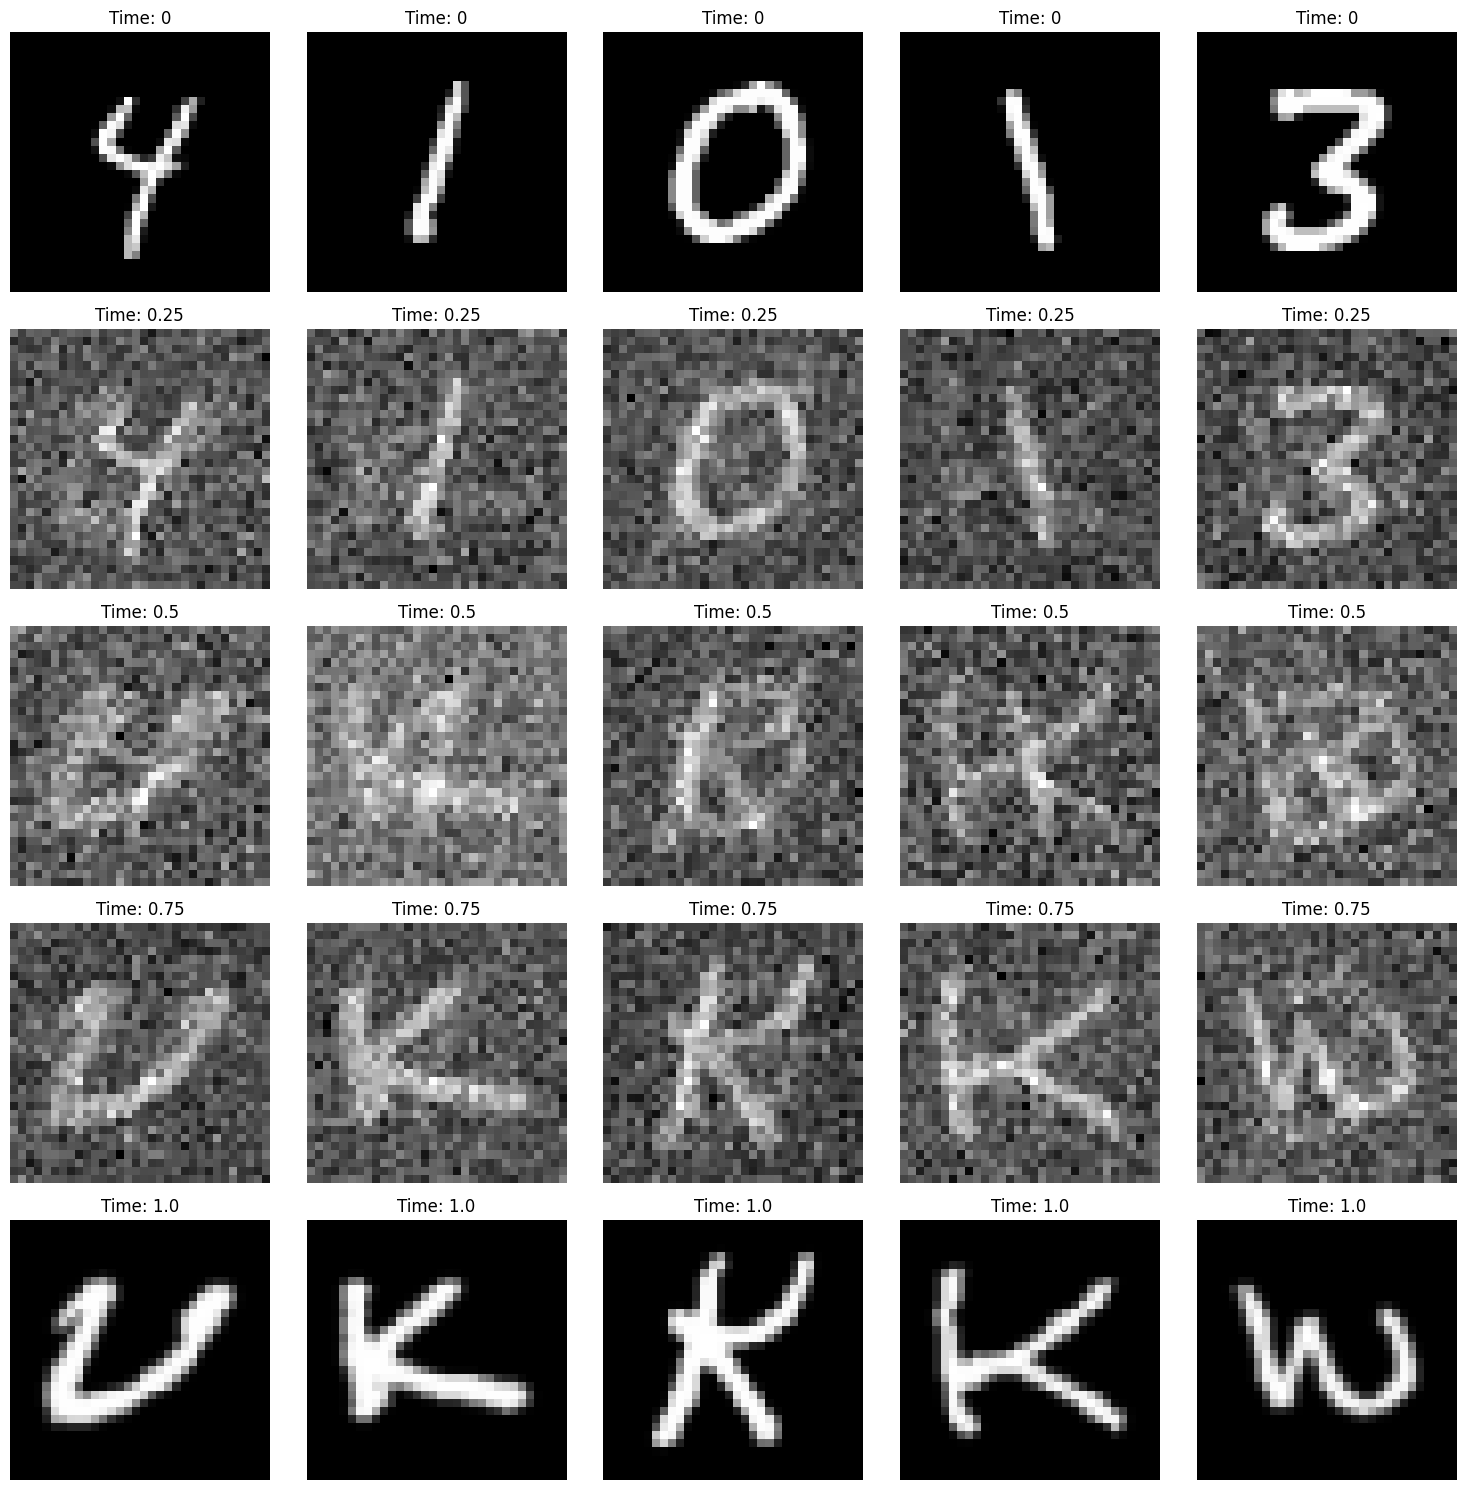

In [7]:
%load_ext autoreload
%autoreload 2

import torch
from diffusion import BridgeDiffusionVPSDE

def apply_diffusion(x, y, sde, time_steps):
    """
    Applies diffusion to a batch of images x for a given set of time steps.
    x: input images 
    y: target images 
    sde: instance of your SDE class
    time_steps: array of time steps at which to visualize the diffusion
    """
    diffused_images = []
    for t in time_steps:
        mu, std = sde.marginal(x, torch.tensor([t]), y)
        noisy_x = mu + std * torch.randn_like(x)
        diffused_images.append(noisy_x)
    return diffused_images

def show_diffused_images(diffused_images, time_steps):
    """
    Visualizes diffused images at different time steps.
    diffused_images: list of tensors containing diffused images at each time step
    time_steps: corresponding time steps
    """
    num_steps = len(time_steps)
    fig, axes = plt.subplots(nrows=num_steps, ncols=5, figsize=(15, 3 * num_steps))
    for i in range(num_steps):
        for j in range(5):
            ax = axes[i, j]
            ax.imshow(diffused_images[i][j].detach().numpy().squeeze(), cmap='gray')
            ax.set_title(f"Time: {time_steps[i]}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

def sample():
    x, y = next(iter(emnist_loader))
    return x

mnist_images, mnist_labels = next(iter(mnist_loader))
emnist_images, emnist_labels = next(iter(emnist_loader))

sde_instance = BridgeDiffusionVPSDE(sample, bmin= .2, bmax=.2)  
time_steps = [0, 0.25, 0.5, 0.75, 1.0]  

diffused_images = apply_diffusion(mnist_images, emnist_images, sde_instance, time_steps)
show_diffused_images(diffused_images, time_steps)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
tensor([0.9999, 0.9989, 0.9979, 0.9969, 0.9959, 0.9949, 0.9939, 0.9929, 0.9919,
        0.9909, 0.9899, 0.9889, 0.9879, 0.9869, 0.9859, 0.9849, 0.9839, 0.9829,
        0.9819, 0.9809, 0.9799, 0.9789, 0.9779, 0.9769, 0.9759, 0.9749, 0.9739,
        0.9729, 0.9719, 0.9709, 0.9699, 0.9689, 0.9679, 0.9669, 0.9659, 0.9649,
        0.9639, 0.9629, 0.9619, 0.9609, 0.9599, 0.9589, 0.9579, 0.9569, 0.9559,
        0.9549, 0.9539, 0.9529, 0.9519, 0.9509, 0.9499, 0.9489, 0.9479, 0.9469,
        0.9459, 0.9449, 0.9439, 0.9429, 0.9419, 0.9409, 0.9399, 0.9389, 0.9379,
        0.9369, 0.9359, 0.9349, 0.9339, 0.9329, 0.9319, 0.9309, 0.9299, 0.9289,
        0.9279, 0.9269, 0.9259, 0.9249, 0.9239, 0.9229, 0.9219, 0.9209, 0.9199,
        0.9189, 0.9179, 0.9169, 0.9159, 0.9149, 0.9139, 0.9129, 0.9119, 0.9109,
        0.9099, 0.9089, 0.9079, 0.9069, 0.9059, 0.9049, 0.9039, 0.9029, 0.9019,
        0.9009, 0.8999, 0.8989, 

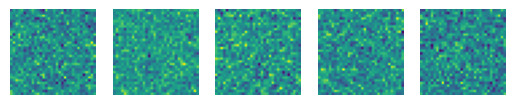

In [15]:
%load_ext autoreload
%autoreload 2
from denoising_diffusion_pytorch import Unet
# Load MNIST dataset
device='cpu'
batch_size=5


mnist_data = torchvision.datasets.MNIST('./data/', transform=tfm, download=True)
mnist_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)

# Load EMNIST dataset
emnist_data = torchvision.datasets.EMNIST('./data/', 'letters', transform=emnist_tfm, download=True)
emnist_loader = DataLoader(emnist_data, batch_size=batch_size, shuffle=True)

def data_y(n):
    # Create a new DataLoader with batch_size = n
    temp_loader = DataLoader(emnist_data, batch_size=n, shuffle=True)

    # Fetch one batch of data
    for data, labels in temp_loader:
        return data # This returns n samples

model = Unet(out_dim=1, channels = 2, dim = 32).to(device)
sde = BridgeDiffusionVPSDE(data_y,  bmin=0.2, bmax=0.2, device = device)

n_examples = 5  # number of examples to generate
with torch.no_grad():
    samples = sde.backward_diffusion(
    model, data_shape=(n_examples, 1, 32, 32)).detach().cpu().numpy()

    _, axes = plt.subplots(1, n_examples)

    for i, ax in enumerate(axes):
        ax.imshow(samples[i].squeeze())
        ax.axis('off')

    plt.show()

torch.Size([10, 1, 32, 32]) torch.Size([10])
